#### Import Libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

The true data generating process for a series $\lbrace x_t \rbrace_{t=1}^{T=200}$ is given by the following AR(1) model:
$$ x_t = \rho_0 x_{t−1} + \epsilon_t, \qquad \epsilon_t \sim N(0,1)$$

where $\rho_0 = 0.5$ and $x_0 = 0$.

The model generation process will be:
$$ y_t(b) = \rho y_{t-1}(b) + e_t, \qquad e_t \sim N(0,\sigma^2) $$

Where $b = (\rho, \sigma^2)$

<ins>Since we do not know the true parameter vector of b, we will estimate it using the simulated method of moments.<ins>

- The **first step** is to define $m$, which denotes a mapping from a $ 1 \times 1 $ vector $ z_t $ (either true data or model-generated pseudodata) to an $ n \times 1 $ moment vector.

We set $n = 3$ and construct the mean, variance, and first-order autocovariance using the following matrix:

$$ m_3(z_t) =\begin{bmatrix}
z_t\\
(z_t-\bar{z})^2\\
(z_t-\bar{z})(z_{t-1}-\bar{z})
\end{bmatrix}$$

- The **second step** is to calculate these three asymptotic moments. The following operations are related to the calculation of these moments:

---

- **Moment of Mean:**
$$E[x_t] = E[\rho_0 x_{t-1}+\epsilon_t]=\rho_0 E[x_{t-1}]+E[\epsilon_t]$$
 Since $E[\epsilon_t]=0$ and $E[x_{0}]=E[0]=0$

$$E[x_t] = 0 \qquad \text{for all}\quad t$$

---

- **Moment of Variance:**
$$\operatorname{Var}[x_t] = E[x_t^2] - (E[x_t])^2 \xRightarrow[{}]{E[x_t]=0} \operatorname{Var}[x_t] = E[x_t^2] $$

$$ E[x_t^2] = E[(\rho_0 x_{t-1}+\epsilon_t)^2] = \rho_0^2 E[x_{t-1}^2] + 2\rho_0 E[x_{t-1}\epsilon_t] + E[\epsilon^2] $$

 Since $\epsilon_t$ is indipendent of $x_{t-1}$ and $E[\epsilon_t]=0$

 $$ E[x_{t-1}\epsilon_t] = E[x_{t-1}]E[\epsilon_t] = 0 $$

 $$ E[x_t^2] = \rho_0^2 E[x_{t-1}^2] + E[\epsilon^2] \rightarrow var = \rho_0^2 var + \sigma_0^2 $$

 Solving for $var$:
 $$ var = \dfrac{\sigma_0^2}{(1-\rho_0^2)} $$
***

- **Moment of First-order Autocovariance:**

$$ \operatorname{Cov}[x_t, x_{t-1}] = E[x_t x_{t-1}] - E[x_t] E[x_{t-1}] \xRightarrow[]{E[x_t]=0} E[x_t x_{t-1}] $$

$$ E[x_t x_{t-1}] = E[(\rho_0 x_{t-1} + \varepsilon_t) x_{t-1}] = \rho_0 E[x_{t-1}^2] + E[\varepsilon_t x_{t-1}] $$

Since $ \varepsilon_t $ is independent of $ x_{t-1} $:

$$ E[x_t x_{t-1}] = \rho_0 E[x_{t-1}^2] = \rho_0 var $$

Then We have,

$$ \operatorname{Cov}[x_t, x_{t-1}] = \rho_0 \times \left( \frac{\sigma_0^2}{1 - \rho_0^2} \right) $$

---

We can write the population (unconditional) moment vector for the true data using $m$ as $\mu(x) = E[m(x)]$.

### **Asymptotic Moments:**

- The population data moments are:
$$ \mu(x) =
\begin{bmatrix}
0\\
\dfrac{\sigma_0^2}{1-\rho_0^2}\\
\rho_0 \times \left( \frac{\sigma_0^2}{1 - \rho_0^2} \right)
\end{bmatrix}=
\begin{bmatrix}
0\\
\dfrac{4}{3}\\
\dfrac{2}{3}
\end{bmatrix}$$

- The Population model moments are:
$$
\mu(y(b)) = \begin{bmatrix}
0\\
\dfrac{\sigma^2}{1-\rho^2}\\
\rho \times \left( \frac{\sigma^2}{1 - \rho^2} \right)
\end{bmatrix}$$

---

### **Computation of $ \nabla_b g(b_0)$:**

To calculate $ \nabla_b g(b_0)$, we must compute the partial derivatives of each moment with respect to $\rho$ and $\sigma$.

- **Moment of Mean:**

$$ \dfrac{\partial E[x_t]}{\partial \rho} = \dfrac{\partial E[x_t]}{\partial \sigma} = 0 $$

---
- **Moment of Variance:**

$$ \dfrac{\partial Var[x_t]}{\partial \rho} = \dfrac{2\rho \sigma^2}{(1-\rho^2)^2}$$

$$ \dfrac{\partial Var[x_t]}{\partial \sigma} = \dfrac{2\sigma}{(1-\rho^2)}$$

---
- **Moment of First-Order Autocovariance:**

$$ \dfrac{\partial Cov[x_t,x_{t-1}]}{\partial \rho} = \dfrac{\sigma^2}{1-\rho^2} + \dfrac{2\sigma^2 \rho^2}{(1-\rho^2)^2} = \frac{\sigma^2 (1 + \rho^2)}{(1 - \rho^2)^2}
$$

$$ \dfrac{\partial Cov[x_t,x_{t-1}]}{\partial \sigma} = \rho \times \dfrac{2\sigma}{(1-\rho^2)}$$

---

A moment is considered informative for estimating a parameter if its derivative with respect to that parameter is non-zero. From the derivations above, we can see that the moment of the mean is not informative, whereas the moments of variance and autocovariance contain valuable information that can help us in the Simulated Method of Moments (SMM) approach.

### **Simulate a series of “true” data**
Set the Parameters

In [44]:
rho = 0.5
T = 200

To construct the AR(1) process, start by:
- Create an initial array X
- Generate T random number from a normal distribution

In [45]:
np.random.seed(111)
x = np.zeros(T+1)
x[0] = 0
eps = np.random.normal(0,1,T+1)

for t in range(1,T+1):
    x[t] = rho * x[t-1] + eps[t]

x = x[1:]

Plot the true data for the AR(1) process

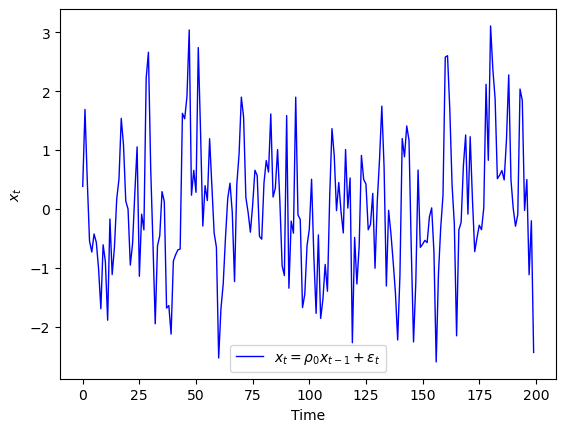

In [46]:
plt.Figure()
plt.plot(x, label=r"$x_t = \rho_0 x_{t-1} + \varepsilon_t$", color = "blue", linewidth=1)
plt.xlabel("Time")
plt.ylabel("$x_t$")
plt.legend()
plt.show()

---

### **True Data Moments: $M_T(x)$**

$$ M_T(x) = \dfrac{1}{T}\sum_{t=1}^T m_3(x_t)$$

In [47]:
xbar = np.mean(x)
m3x = np.zeros((3,T))

for t in range(T):
    m3x[0,t] = x[t] 
    m3x[1,t] = (x[t] - xbar)**2
    
    if t == 0 :
        x_prev = 0
    else :
        x_prev = x[t - 1]
        
    m3x[2,t] = (x[t] - xbar)*(x_prev - xbar)

MT_x = np.mean(m3x, axis = 1) 
MT_x

array([0.02300667, 1.31465318, 0.66651158])

---

### **Simulated Data Moments: $ M_{TH}(y(b)) $**

- $e_t$: Contructing a matrix of random white noise $ \rightarrow e_{10 \times 200}$
- simul_data: Use $\rho$ and $\sigma$ to create a $(10 \times 200)$ matrix, resulting in 10 simulated time series, each with $T$ observations.

$$y_{i,j} = \rho \times y_{i,j-1} + \sigma \times e_{i,j}$$
 - $i$ in range $H$
 - $j$ in range $(1, T+1)$

In [48]:
np.random.seed(111)
H = 10
e = np.random.normal(0, 1, (H, T + 1))

def simul_data(rho, sigma):
    y = np.zeros((H, T + 1))
    for i in range(H):
        for j in range(1, T + 1):
            y[i][j] = rho * y[i][j - 1] + sigma * e[i][j]
    y = y[:, 1:]
    return y

- Calculate the three moments of the simulated data using $\rho$ and $\sigma$.
- Compute the mean across $H$ simulations and $T$ observations.

$$M_{TH} (y(b)) = \dfrac{1}{TH} \sum_{t=1}^T \sum_{h=1}^H  m_3(y_t^h(b))$$

In [49]:
def simul_moment(rho,sigma):
    y = simul_data(rho, sigma)
    y_bar = []
    m3y = np.zeros((3,H,T))

    for h in range(H):
        y_bar.append(np.mean(y[h]))
        for t in range(T):
            m3y[0,h,t] = y[h][t]
            m3y[1,h,t] = (y[h][t] - y_bar[h])**2
            if t == 0:
                y_prev = 0
            else:
                y_prev = (y[h][t-1])
            m3y[2,h,t] = (y[h][t] - y_bar[h])*(y_prev - y_bar[h])

    MTH_y = []
    for i in range(3):
        MTH_y.append(np.mean(m3y[i], axis = 0))
    MTH_y = np.mean(MTH_y, axis = 1)

    return (MTH_y, m3y)

---

Let the objective function be given by:

$$
J_{TH}(b) \equiv [M_T(x) - M_{T_H}(y(b))]' \, W \, [M_T(x) - M_{T_H}(y(b))]
$$
where;
- $g_{TH}(b) ≡ M_T(x) - M_{TH}(y(b))$ is an $n \times 1$ vector with the distance between data moments and model moments
- $W$ is a positive semi-definite weighting matrix.

The SMM estimate $\hat{b}_{TH}$,
$$
\hat{b}_{TH} = \arg \min_b J_{TH}(b)
$$

In [50]:
def obj_func(par_ls, w = np.eye(3), moment_idx=[0,1,2]):
    rho , sigma = par_ls
    MTH_y = simul_moment(rho, sigma)[0].reshape(-1,1)
    MT_x1 = MT_x.reshape(-1,1)
    MTH_y = MTH_y[moment_idx]
    MT_x1 = MT_x1[moment_idx]
    diff = MT_x1 - MTH_y
    JTH = diff.T @ w @ diff
    return JTH.item()

---

### **Just Identified Case $m_2(x):$ (Using Mean & Variance)**

**Plot Objective Function vs $\sigma$**

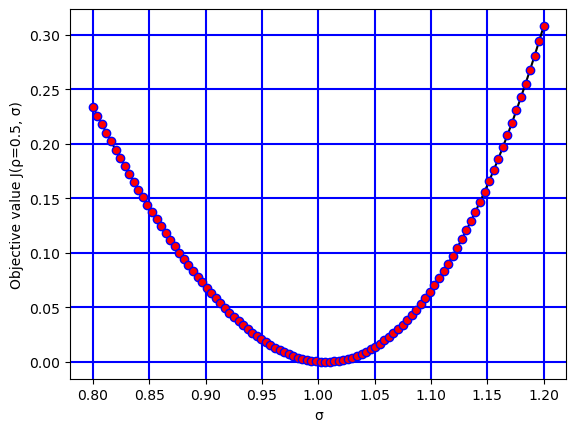

In [51]:
rho_fixed = 0.5
sigma_vals = np.linspace(0.8, 1.2, 100)

J_vals = [obj_func([rho_fixed, s], w=np.eye(2), moment_idx=[0, 1]) for s in sigma_vals]

plt.figure()
plt.plot(sigma_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("σ")
plt.ylabel("Objective value J(ρ=0.5, σ)")
plt.grid(True, color='blue', linewidth=1.5)
plt.show()

**Plot Objective Function vs $\rho$**

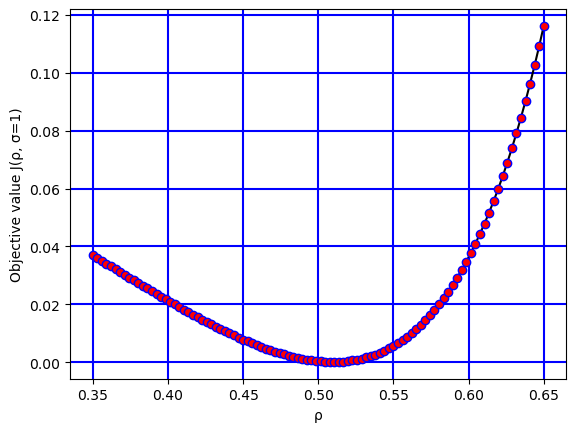

In [52]:
sigma_fixed = 1.0
rho_vals = np.linspace(0.35, 0.65, 100)
J_vals = [obj_func([r, sigma_fixed], w=np.eye(2), moment_idx=[0, 1]) for r in rho_vals]

plt.figure()
plt.plot(rho_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("ρ")
plt.ylabel("Objective value J(ρ, σ=1)")
plt.grid(True, color="b", linewidth=1.5)
plt.show()

**Plot Objective Function (3D)**

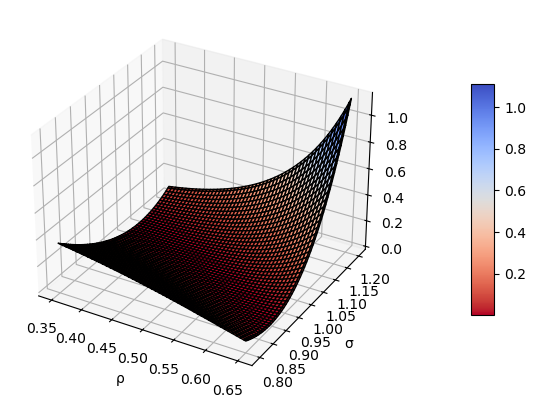

In [53]:
Rho, Sigma = np.meshgrid(rho_vals, sigma_vals)

J = np.zeros_like(Rho)
for i in range(Rho.shape[0]):
    for j in range(Rho.shape[1]):
        J[i, j] = obj_func([Rho[i, j], Sigma[i, j]], w=np.eye(2), moment_idx=[0, 1])

fig3D = plt.figure(figsize=(7, 6))
ax = fig3D.add_subplot(111, projection = '3d')
surface = ax.plot_surface(Rho, Sigma, J, cmap = "coolwarm_r", edgecolor = "k")

ax.set_xlabel('ρ')
ax.set_ylabel('σ')

fig3D.colorbar(surface, shrink=0.5, aspect=10, pad=0.15)
plt.show()

---

**Report $\hat{b}_{1TH}$**

In [54]:
result1 = minimize(obj_func, np.array([0.5, 1.0]), args = (np.eye(2), [0,1]), method = "BFGS")

optimal_rho1 = result1.x[0]
optimal_sigma1 = result1.x[1]
print(f" b1 (TH) : [{optimal_rho1} , {optimal_sigma1}]")

 b1 (TH) : [0.24514311443824513 , 1.1168201932039015]


Since the mean moment provides no information for estimating parameters via Simulated Method of Moments (SMM), the optimization results is not close to the true parameters. 

We use the **"BFGS"** method to minimize the objective function value, as it is one of the most commonly used techniques for optimization. 

This method operates similarly to Newton’s method, constructing an approximation of the Hessian (or its inverse) by utilizing information from previous iterations.

**Experiment with different parameters for the optimizer of "BFGS"**

In [55]:
init_guess = [
    [0.35, 0.8],
    [0.4, 0.9],
    [0.5, 1.0],
    [0.6, 1.1],
    [0.65, 1.2]]

results1 = []
times1 = []

for i in init_guess:
    start = time.time()
    res = minimize(obj_func, i, args = (np.eye(2), [0, 1]), method = "BFGS")
    end = time.time()
    
    results1.append(res)
    times1.append(end - start)

for i, (res, t) in enumerate(zip(results1, times1)):
    print(f"\nInitial guess {i+1}: {init_guess[i]}")
    print(f"  Computing Time: {t:.4f} seconds")
    print(f"  Optimal Parameters: {res.x}")
    print(f" Objective Funcation Value: {res.fun}")
    print("=" * 50)


Initial guess 1: [0.35, 0.8]
  Computing Time: 0.2470 seconds
  Optimal Parameters: [0.24540067 1.11675106]
 Objective Funcation Value: 5.642847005782047e-11

Initial guess 2: [0.4, 0.9]
  Computing Time: 0.2510 seconds
  Optimal Parameters: [0.24513625 1.11682182]
 Objective Funcation Value: 1.109999709960714e-12

Initial guess 3: [0.5, 1.0]
  Computing Time: 0.2616 seconds
  Optimal Parameters: [0.24514311 1.11682019]
 Objective Funcation Value: 2.0684586518876163e-12

Initial guess 4: [0.6, 1.1]
  Computing Time: 0.1572 seconds
  Optimal Parameters: [0.24511004 1.11682851]
 Objective Funcation Value: 8.483566131395537e-14

Initial guess 5: [0.65, 1.2]
  Computing Time: 0.5903 seconds
  Optimal Parameters: [0.24509707 1.11683194]
 Objective Funcation Value: 1.0231986551364412e-15


After experimenting with different initial guesses using the **'BFGS'** method, we found that the choice of initial guess affects both the computing time and the minimized value of the objective function. However, it still does not bring our estimates closer to the true parameters.

---

To find the efficient estimator, we need to determine the optimal weighting matrix $W^*_{TH}$. 
One possible estimate of the asymptotic variance-covariance matrix $S$, denoted as $\hat{S}_{TH}$, can be obtained from the simulated data at $b = \hat{b}_{1TH}$ using the estimator.

$$
\hat{S}_{TH} = \frac{1}{TH} \sum_{h=1}^{H} \sum_{t=1}^{T}
\big[ M_T(x) - M_{TH}(y(\hat{b}_{1TH})) \big]
\big[ M_T(x) - M_{TH}(y(\hat{b}_{1TH})) \big]'
$$
Where, 
$$
\hat{W}^*_{TH} = \hat{S}^{-1}_{TH}
$$

**Optimal Weighting Matrix $W^*$**

In [56]:
mtx = MT_x[[0, 1]].reshape(2, 1, 1)
mthb = simul_moment(optimal_rho1, optimal_sigma1)[1][[0,1]]
Error = (mtx - mthb).reshape(2, -1)
S_TH1 = (Error @ Error.T) / (H * T)
W1 = np.linalg.inv(S_TH1)
W1

array([[0.75494706, 0.00173535],
       [0.00173535, 0.27707019]])

**Report $\hat{b}_{2TH}$**

In [57]:
result2 = minimize(obj_func, np.array([0.5, 1.0]), args = (W1, [0,1]), method = "BFGS")

optimal_rho2 = result2.x[0]
optimal_sigma2 = result2.x[1]
print(f" b2 (TH) : [{optimal_rho2} , {optimal_sigma2}]")

 b2 (TH) : [0.24510676124686834 , 1.1168291790556746]


---

The estimate of the variance-covariance matrix of the estimator $\hat{b}_{2TH}$ can be obtained using $\hat{S}_{TH}$ and $\nabla_b g_{T}(\hat{b}_{2TH})$. 

In general, we cannot obtain this derivative analytically, so we will use an approximation for $\nabla_b g_{T}(\hat{b}_{2TH})$. 

In the current case, we have two parameters $(\rho, \sigma)$, so we have to compute the derivative for both dimensions. First,we can compute $M_{TH} (y(\hat{b}_{1TH}))$, then compute $M_{TH} (y(\hat{b}_{1TH} - s_{\rho}))$ and $M_{TH} (y(\hat{b}_{1TH} - s_{\sigma}))$ where $s_{\rho} =[s,0]'$ and $s_{\sigma} =[0,s]'$ and $s$ is a **small number**. Then take the difference, and divide by the step size $s$ to get the $n \times 1$ vector:

$$
\frac{\partial g_T(\hat{b}_{2TH})}{\partial \rho} 
\approx 
- \frac{M_{TH}(y(\hat{b}_{2TH})) - M_{TH}(y(\hat{b}_{2TH} - s_{\rho}))}{s_\rho}
$$

$$
\frac{\partial g_T(\hat{b}_{2TH})}{\partial \sigma} 
\approx 
- \frac{M_{TH}(y(\hat{b}_{2TH})) - M_{TH}(y(\hat{b}_{2TH} - s_{\sigma}))}{s_\sigma}
$$
Then,
$$
\nabla_{b} g_T(\hat{b}_{2TH}) 
= 
\begin{bmatrix}
\frac{\partial g_T(\hat{b}_{2TH})}{\partial \rho} &
\frac{\partial g_T(\hat{b}_{2TH})}{\partial \sigma}
\end{bmatrix}
$$

**Report $\nabla_{b} g_T(\hat{b}_{2TH})$**


In [58]:
eps = 0.001
diff_rho = (simul_moment(optimal_rho2, optimal_sigma2)[0][[0,1]].reshape(-1,1) - simul_moment(optimal_rho2 - eps, optimal_sigma2)[0][[0,1]].reshape(-1,1))/eps
diff_sigma = (simul_moment(optimal_rho2, optimal_sigma2)[0][[0,1]].reshape(-1,1) - simul_moment(optimal_rho2, optimal_sigma2 - eps)[0][[0,1]].reshape(-1,1))/eps

gradiant_g1 = np.hstack((diff_rho, diff_sigma))
print(gradiant_g1)

[[0.02941654 0.02060018]
 [0.61868839 2.35320526]]


We can obtain the variance-covariance matrix of $\hat{b}_{1TH}$ by computing:

$$
\frac{1}{T} 
\left[
\nabla_{b} g_T(\hat{b}_{2TH})' 
\hat{S}_{TH}^{-1} 
\nabla_{b} g_T(\hat{b}_{2TH})
\right]^{-1}
$$

In [59]:
cov_var_mtx1 = np.linalg.inv((gradiant_g1.T @ W1 @ gradiant_g1))/T
cov_var_mtx1

array([[11.50159019, -3.02744986],
       [-3.02744986,  0.80014348]])

Finally, standard errors can be obtained from the square root of the diagonal of the variance-covariance matrix
$$
\sqrt{
\operatorname{diag}
\left(
\frac{1}{T}
\left[
\nabla_{b} g_T(\hat{b}_{2TH})' 
\hat{S}_{TH}^{-1} 
\nabla_{b} g_T(\hat{b}_{2TH})
\right]^{-1}
\right)
}
$$


In [60]:
SE1 = np.sqrt(np.diag(cov_var_mtx1))
print(f" Standard Error of rho:", SE1[0])
print(f" Standard Error of sigma:", SE1[1])

 Standard Error of rho: 3.39139944446804
 Standard Error of sigma: 0.8945073938416062


The optimal values obtained are $\rho = 0.245$ and $\sigma = 1.116$, but these do not closely correspond to the true parameters. This difference arises from the fact that we are only considering the first two identified moments: the mean and the variance. From the first part of our analysis, we found that the moment of the mean provides no information because its derivative with respect to the parameters $\rho$ and $\sigma$ is zero. This issue complicates the selection of the mean as a moment in the SMM process.

In the next section, we will examine estimation in the case of just identified moments, focusing specifically on the variance and autocorrelation, as the moment of the mean will not play a role in this analysis.

---

### **Just Identified Case $m_2(x)$ (Using Variance & Autocorrelation)**

**Plot Objective Function vs $\sigma$**

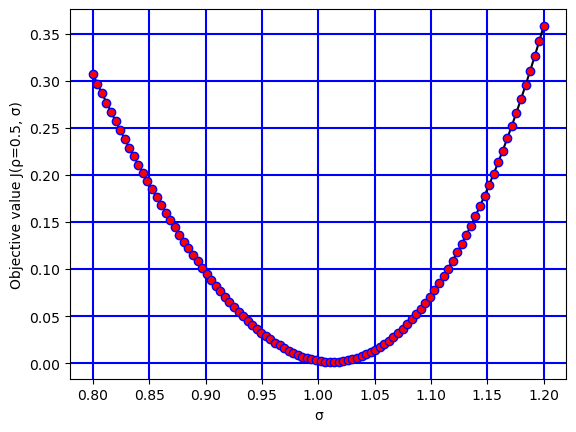

In [61]:
rho_fixed = 0.5
sigma_vals = np.linspace(0.8, 1.2, 100)

J_vals = [obj_func([rho_fixed, s], w=np.eye(2), moment_idx=[1, 2]) for s in sigma_vals]

plt.figure()
plt.plot(sigma_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("σ")
plt.ylabel("Objective value J(ρ=0.5, σ)")
plt.grid(True, color='blue', linewidth=1.5)
plt.show()

**Plot Objective Function vs $\rho$**

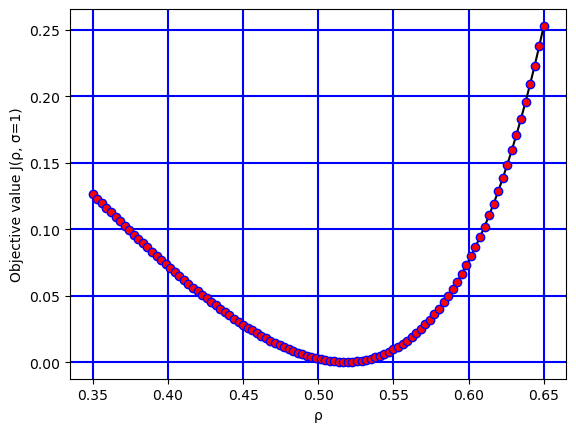

In [62]:
sigma_fixed = 1.0
rho_vals = np.linspace(0.35, 0.65, 100)
J_vals = [obj_func([r, sigma_fixed], w=np.eye(2), moment_idx=[1, 2]) for r in rho_vals]

plt.figure()
plt.plot(rho_vals, J_vals, marker='.', markersize=12,
    markerfacecolor='red', markeredgecolor='blue',
    linestyle='-', color='black')
plt.xlabel("ρ")
plt.ylabel("Objective value J(ρ, σ=1)")
plt.grid(True, color="b", linewidth=1.5)
plt.show()

**Plot Objective Function (3D)**

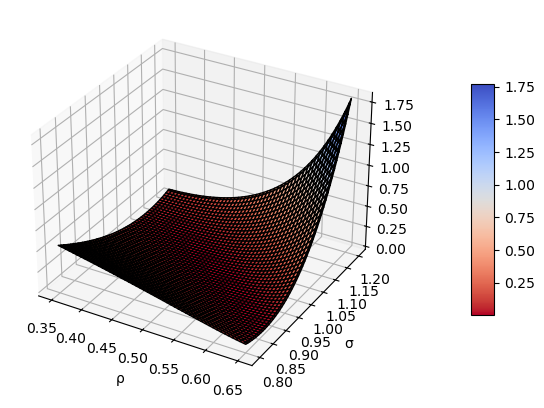

In [63]:
Rho, Sigma = np.meshgrid(rho_vals, sigma_vals)

J = np.zeros_like(Rho)
for i in range(Rho.shape[0]):
    for j in range(Rho.shape[1]):
        J[i, j] = obj_func([Rho[i, j], Sigma[i, j]], w=np.eye(2), moment_idx=[1, 2])

fig3D = plt.figure(figsize=(7, 6))
ax = fig3D.add_subplot(111, projection = '3d')
surface = ax.plot_surface(Rho, Sigma, J, cmap = "coolwarm_r", edgecolor = "k")

ax.set_xlabel('ρ')
ax.set_ylabel('σ')

fig3D.colorbar(surface, shrink=0.5, aspect=10, pad=0.15)
plt.show()

---

**Report $\hat{b}_{1TH}$**

In [64]:
result1 = minimize(obj_func, np.array([0.5, 1.0]), args = (np.eye(2), [1,2]), method = "BFGS")

optimal_rho3 = result1.x[0]
optimal_sigma3 = result1.x[1]
print(f" b1 (TH) : [{optimal_rho3} , {optimal_sigma3}]")

 b1 (TH) : [0.5305943248678261 , 0.9863899637320709]


By using variance and autocorrelation instead of mean and variance moments, we obtain parameters that are closer to the true values.

**Experiment with different parameters for the optimizer of "BFGS"**

In [65]:
init_guess = [
    [0.35, 0.8],
    [0.4, 0.9],
    [0.5, 1.0],
    [0.6, 1.1],
    [0.65, 1.2]]

results2 = []
times2 = []

for i in init_guess:
    start = time.time()
    res = minimize(obj_func, i, args = (np.eye(2), [1, 2]), method = "BFGS")
    end = time.time()
    
    results2.append(res)
    times2.append(end - start)

for i, (res, t) in enumerate(zip(results2, times2)):
    print(f"\nInitial guess {i+1}: {init_guess[i]}")
    print(f"  Computing Time: {t:.4f} seconds")
    print(f"  Optimal Parameters: {res.x}")
    print(f" Objective Funcation Value: {res.fun}")
    print("=" * 50)


Initial guess 1: [0.35, 0.8]
  Computing Time: 0.1136 seconds
  Optimal Parameters: [0.53059479 0.9863899 ]
 Objective Funcation Value: 8.900009892743899e-13

Initial guess 2: [0.4, 0.9]
  Computing Time: 0.0772 seconds
  Optimal Parameters: [0.5305944  0.98638994]
 Objective Funcation Value: 8.971797440394866e-15

Initial guess 3: [0.5, 1.0]
  Computing Time: 0.0534 seconds
  Optimal Parameters: [0.53059432 0.98638996]
 Objective Funcation Value: 5.2019295057149214e-14

Initial guess 4: [0.6, 1.1]
  Computing Time: 0.0925 seconds
  Optimal Parameters: [0.53059413 0.98639028]
 Objective Funcation Value: 1.6776689971494477e-13

Initial guess 5: [0.65, 1.2]
  Computing Time: 0.1254 seconds
  Optimal Parameters: [0.53059519 0.98638951]
 Objective Funcation Value: 1.2779354991257524e-12


**Optimal Weighting Matrix $W^*$**

In [66]:
mtx = MT_x[[0, 1]].reshape(2, 1, 1)
mthb = simul_moment(optimal_rho1, optimal_sigma1)[1][[0,1]]
Error = (mtx - mthb).reshape(2, -1)
S_TH2 = (Error @ Error.T) / (H * T)
W2 = np.linalg.inv(S_TH2)
W2

array([[0.75494706, 0.00173535],
       [0.00173535, 0.27707019]])

**Report $\hat{b}_{2TH}$**

In [67]:
result2 = minimize(obj_func, np.array([0.5, 1.0]), args = (W2, [1,2]), method = "BFGS")

optimal_rho4 = result2.x[0]
optimal_sigma4 = result2.x[1]
print(f" b2 (TH) : [{optimal_rho4} , {optimal_sigma4}]")

 b2 (TH) : [0.530596172878891 , 0.98638885114481]


**Report $\nabla_{b} g_T(\hat{b}_{2TH})$**

In [68]:
eps = 0.001
diff_rho = (simul_moment(optimal_rho4, optimal_sigma4)[0][[0,1]].reshape(-1,1) - simul_moment(optimal_rho4 - eps, optimal_sigma4)[0][[0,1]].reshape(-1,1))/eps
diff_sigma = (simul_moment(optimal_rho4, optimal_sigma4)[0][[0,1]].reshape(-1,1) - simul_moment(optimal_rho4, optimal_sigma4 - eps)[0][[0,1]].reshape(-1,1))/eps

gradiant_g2 = np.hstack((diff_rho, diff_sigma))
print(gradiant_g2)

[[0.06764352 0.03272687]
 [1.79885758 2.66423738]]


In [69]:
cov_var_mtx2 = np.linalg.inv((gradiant_g2.T @ W2 @ gradiant_g2))/T
cov_var_mtx2

array([[ 3.19440473, -2.15898814],
       [-2.15898814,  1.46172663]])

In [70]:
SE2 = np.sqrt(np.diag(cov_var_mtx2))
print(f" Standard Error of rho:", SE2[0])
print(f" Standard Error of sigma:", SE2[1])

 Standard Error of rho: 1.7872897734623387
 Standard Error of sigma: 1.209018869946237


In this section, we obtained optimal parameters of $\rho = 0.53$ and $\sigma = 0.98$. The standard errors for these parameters are lower than the last part. Therefore, we conclude that the selection of these moments—variance and first-order autocorrelation—is a much more suitable choice for the case of just identified $m_2$.

---

### **Over Identified Case $m_3(x)$ (Using Mean & Variance & Autocorrelation)**